In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [5]:
# ------------------ Fonctions utilitaires ------------------

def validate_date(prompt, default=None, prices=None):
    """
    Valide une date entrée par l'utilisateur.
    Si `prices` est fourni, vérifie que la date correspond à un jour ouvré dans les données.
    """
    while True:
        try:
            date_input = input(f"{prompt} (par défaut : {default}) : ").strip()
            if not date_input and default:
                date_input = default
            date = dt.datetime.strptime(date_input, "%Y-%m-%d").date()

            if prices is not None and date not in pd.to_datetime(prices.index).date:
                print(f"Erreur : La date {date} doit être un jour ouvré présent dans les données.")
                continue

            return date
        except ValueError:
            print("Erreur : La date entrée n'est pas valide. Veuillez respecter le format AAAA-MM-JJ.")

def validate_date_range(prompt_start, prompt_end, default_start=None, default_end=None, prices=None):
    """
    Valide une plage de dates entrée par l'utilisateur avec des valeurs par défaut.
    """
    while True:
        start_date = validate_date(prompt_start, default_start, prices)
        end_date = validate_date(prompt_end, default_end, prices)

        if start_date > end_date:
            print("Erreur : La date de fin doit être postérieure ou égale à la date de début.")
            continue

        return start_date, end_date

def validate_ticker(default="AAPL"):
    """
    Valide le ticker de l'action en vérifiant qu'il contient des données.
    """
    while True:
        ticker = input(f"Entrez le ticker de l'action (par ex. AAPL, MSFT, TSLA) (par défaut : {default}) : ").strip().upper()
        ticker = ticker if ticker else default
        try:
            stock = yf.Ticker(ticker)
            prices = stock.history(period="1d")  # Vérification minimaliste
            if prices.empty:
                print(f"Erreur : Le ticker '{ticker}' ne contient pas de données valides.")
                continue
            return ticker
        except Exception as e:
            print(f"Erreur : Impossible de valider le ticker '{ticker}'. Détails : {e}")

In [6]:
# ------------------ Fonctions principales ------------------

def download_prices(ticker, start_date, end_date):
    """
    Télécharge les données de prix de clôture pour une période donnée.
    Gère les valeurs manquantes.
    """
    print(f"Téléchargement des données pour {ticker} de {start_date} à {end_date}...")
    prices = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))[['Close']]
    if prices.empty:
        raise ValueError(f"Aucune donnée téléchargée pour {ticker}. Vérifiez les dates ou le ticker.")
    if prices.isnull().values.any():
        print("Attention : Des valeurs manquantes ont été détectées. Elles seront remplacées par ffill() et bfill().")
        prices = prices.ffill().bfill()
    print(f"Données téléchargées avec succès pour {ticker}.")
    return prices

def calculate_stat_returns(prices, start_sub_period=None, end_sub_period=None):
    """
    Calcule les rendements logarithmiques, leur moyenne et leur écart-type pour une période donnée.
    """
    if start_sub_period and end_sub_period:
        prices = prices.loc[start_sub_period:end_sub_period]
    if prices.empty:
        raise ValueError(f"Aucune donnée disponible pour la période {start_sub_period} à {end_sub_period}.")
    returns = np.log(prices['Close']).diff().dropna()
    return returns, returns.mean(), returns.std()

def monte_carlo_simulation(ticker, prices, nb_simulation, nb_step, initial_date, initial_price, mean, std, risk_free_rate):
    """
    Effectue une simulation Monte Carlo, trace les résultats et calcule le prix équitable.
    """
    # Génération des simulations
    dates = pd.date_range(start=initial_date, periods=nb_step + 1, freq='B')
    simulations = np.zeros((nb_simulation, nb_step + 1))

    for i in range(nb_simulation):
        random_walk = np.random.normal(mean, std, nb_step)
        simulations[i, :] = initial_price * np.exp(np.cumsum(np.insert(random_walk, 0, 0)))

    # Calcul du prix équitable
    final_prices = simulations[:, -1]
    mean_final_price = np.mean(final_prices)
    t = (dates[-1] - dates[0]).days / 365
    fair_price = mean_final_price * np.exp(-risk_free_rate * t)

    # Visualisation
    plt.figure(figsize=(12, 8))
    plt.plot(prices.index, prices['Close'], color='red', linewidth=2, label=f'Historique des prix de {ticker}')
    plt.scatter(initial_date, initial_price, color='black', zorder=3, label="Début des simulations")
    for i in range(min(nb_simulation, 10)):  # Tracer un sous-ensemble des simulations
        plt.plot(dates, simulations[i, :], linewidth=1, alpha=0.6)
    plt.title(f"Simulation Monte Carlo pour {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Prix")
    plt.legend()
    plt.grid()
    plt.show()

    return fair_price

In [7]:
# Définitions des valeurs par défaut cohérentes
default_start_date = "2023-01-03"
default_end_date = "2024-12-31"
default_start_sub_period = "2023-01-03"
default_end_sub_period = "2024-03-01"
default_start_sim_period = "2024-03-04"
default_end_sim_period = "2024-12-03"
default_nb_simulation = 100
risk_free_rate = 0.03

Téléchargement des données pour AAPL de 2023-01-03 à 2024-12-31...


[*********************100%***********************]  1 of 1 completed


Données téléchargées avec succès pour AAPL.
Rendements calculés pour la période 2023-01-03 à 2024-03-01 :
Valeur attendue (moyenne des rendements) : 0.001245
Écart-type des rendements : 0.012487


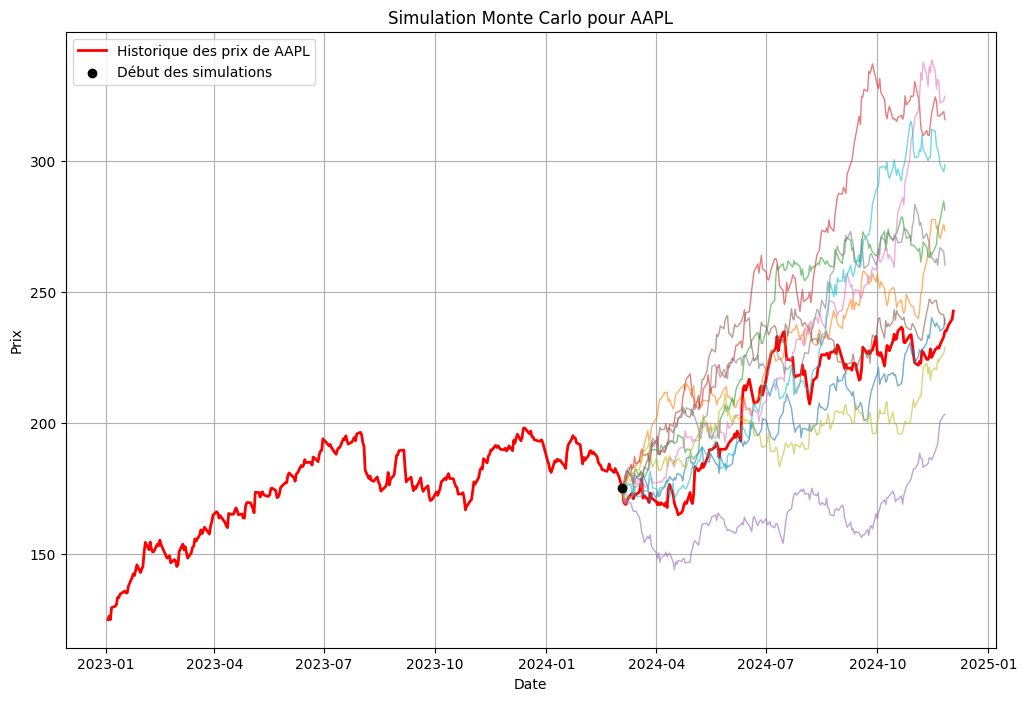


Le prix équitable estimé pour AAPL est de : 227.83


In [8]:
# Validation du ticker
ticker = validate_ticker()

# Validation de la période globale
start_date, end_date = validate_date_range(
    f"Entrez la date de début du téléchargement de l'historique des prix de {ticker} :",
    f"Entrez la date de fin du téléchargement de l'historique des prix de {ticker} :",
    default_start_date,
    default_end_date
)

# Téléchargement des données
prices = download_prices(ticker, start_date, end_date)

# Validation de la sous-période pour les paramètres statistiques
start_sub_period, end_sub_period = validate_date_range(
    f"Entrez la date de début pour le calcul des paramètres statistiques de {ticker} :",
    f"Entrez la date de fin pour le calcul des paramètres statistiques de {ticker} :",
    default_start_sub_period,
    default_end_sub_period,
    prices
)

# Calcul des rendements
returns, mean, std = calculate_stat_returns(prices, start_sub_period, end_sub_period)
print(f"Rendements calculés pour la période {start_sub_period} à {end_sub_period} :")
print(f"Valeur attendue (moyenne des rendements) : {mean:.6f}")
print(f"Écart-type des rendements : {std:.6f}")

# Validation de la sous-période pour les marches aléatoires
start_sim_period = validate_date(
    f"Entrez la date de début pour les marches aléatoires :",
    default_start_sim_period,
    prices
)

nb_simulation = int(input(f"Entrez le nombre de simulations à effectuer (par défaut : {default_nb_simulation}) : ") or default_nb_simulation)

# Simulation Monte Carlo
fair_price = monte_carlo_simulation(
    ticker, prices, nb_simulation, len(prices.loc[start_sim_period:]), start_sim_period,
    prices.loc[pd.Timestamp(start_sim_period), 'Close'] , mean, std, risk_free_rate
)
print(f"\nLe prix équitable estimé pour {ticker} est de : {fair_price:.2f}")